# Bag of Words Meets Bags of Popcorn

# Introduction

This project performs sentiment analysis on IMDB movie reviews. 
We use a combination of text preprocessing, Word2Vec embeddings, 
and a RandomForest classifier to predict whether a review is 
positive (1) or negative (0). 

The workflow includes:
1. Data Import
2. Exploratory Data Analysis (EDA)
3. Data Cleaning & Preprocessing
4. Word2Vec Embedding & Feature Extraction
5. Model Training & Evaluation
6. Test Set Predictions & Submission

# Requirements

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Data Import

In [6]:
train = pd.read_csv("labeledTrainData.tsv", delimiter="\t", quoting=3)

In [8]:
test = pd.read_csv("testData.tsv", delimiter="\t", quoting=3)

In [9]:
unlabeled = pd.read_csv("unlabeledTrainData.tsv", delimiter="\t", quoting=3)

In [11]:
sample_submission = pd.read_csv("sampleSubmission.csv")

In [12]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [16]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [18]:
unlabeled.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [20]:
sample_submission.head()

,id,sentiment
0,12311_10,0
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,0


# EDA (Exploratory Data Analysis)

In [23]:
train.shape

(25000, 3)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [27]:
train.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

In [29]:
train.tail()

,id,sentiment,review
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


# Data Visualization

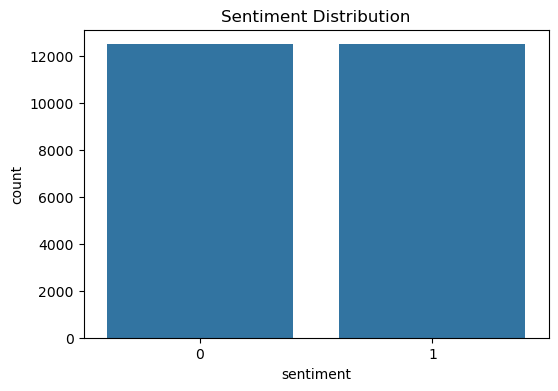

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=train)
plt.title("Sentiment Distribution")
plt.show()

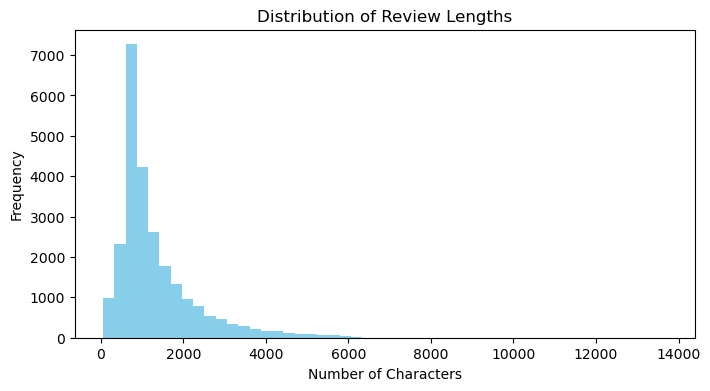

In [34]:
train["review_len"] = train["review"].apply(len)
plt.figure(figsize=(8,4))
plt.hist(train["review_len"], bins=50, color="skyblue")
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

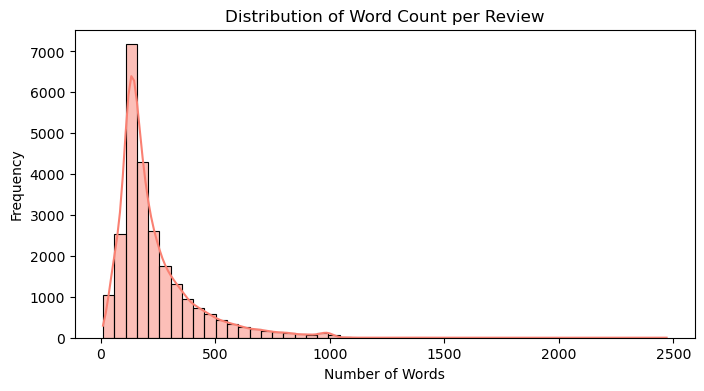

In [35]:
train["word_count"] = train["review"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(train["word_count"], bins=50, kde=True, color="salmon")
plt.title("Distribution of Word Count per Review")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [37]:
from collections import Counter
import re
all_words = ' '.join(train['review']).lower()
all_words = re.sub(r'[^a-zA-Z\s]', '', all_words)
word_list = all_words.split()
word_counts = Counter(word_list)
top_words = word_counts.most_common(20)

C:\Users\acer\AppData\Local\Temp\ipykernel_18564\223620988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


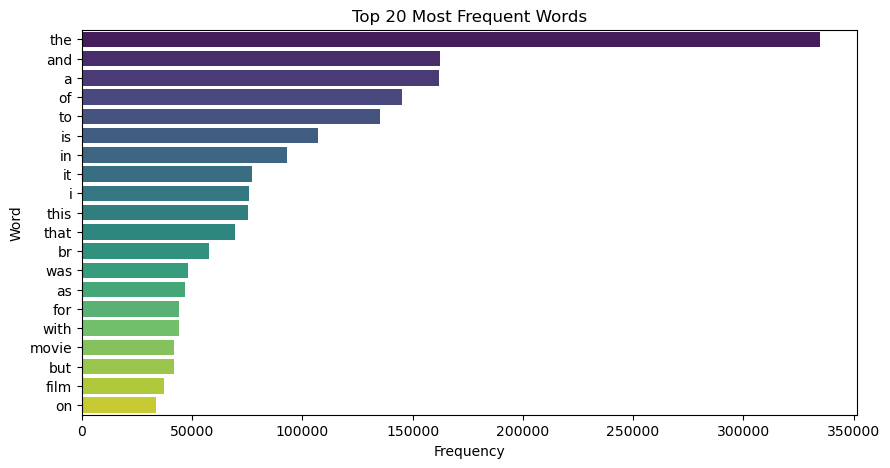

In [38]:
words, counts = zip(*top_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

# Data Cleaning / Preprocessing

In [44]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [46]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # 2. Keep only letters
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # 3. Convert to lowercase
    text = text.lower()
    # 4. Tokenize
    words = word_tokenize(text)
    # 5. Remove stopwords
    words = [w for w in words if w not in stop_words and len(w) > 1]
    return words

In [50]:
train["cleaned"] = train["review"].apply(clean_text)
test["cleaned"] = test["review"].apply(clean_text)
unlabeled["cleaned"] = unlabeled["review"].apply(clean_text)

In [53]:
print(train[["review", "cleaned"]].head())

                                              review  \
0  "With all this stuff going down at the moment ...   
1  "\"The Classic War of the Worlds\" by Timothy ...   
2  "The film starts with a manager (Nicholas Bell...   
3  "It must be assumed that those who praised thi...   
4  "Superbly trashy and wondrously unpretentious ...   

                                             cleaned  
0  [stuff, going, moment, mj, started, listening,...  
1  [classic, war, worlds, timothy, hines, enterta...  
2  [film, starts, manager, nicholas, bell, giving...  
3  [must, assumed, praised, film, greatest, filme...  
4  [superbly, trashy, wondrously, unpretentious, ...  


 # Word2Vec Embedding & Feature Extraction

In [55]:
from gensim.models import Word2Vec
import numpy as np

sentences = train["cleaned"].tolist() + unlabeled["cleaned"].tolist()

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

def vectorize_review(words, model, size=100):
    vec = np.zeros(size)
    count = 0
    for word in words:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

In [56]:
X_train = np.array([vectorize_review(x, w2v_model) for x in train["cleaned"]])
y_train = train["sentiment"].values
X_test = np.array([vectorize_review(x, w2v_model) for x in test["cleaned"]])

# Model Training & Evaluation

Validation Accuracy: 0.8426


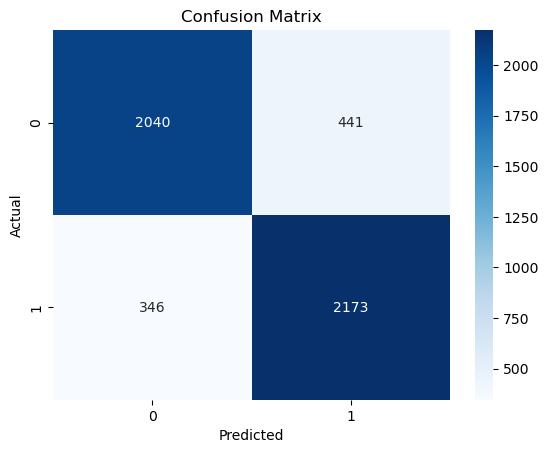

In [60]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split train data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train RandomForest (fewer trees for speed)
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", acc)

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [64]:
test_pred = clf.predict(X_test) 

In [66]:
submission = pd.DataFrame({
    "id": test["id"],
    "sentiment": test_pred
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("submission.csv created successfully!")

submission.csv created successfully!
